<a href="https://colab.research.google.com/github/hisunnytang/HaloEGNN/blob/main/notebooks/HaloEGNN_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torchdiffeq
!pip install gdown
!git clone https://github.com/hisunnytang/HaloEGNN.git

In [2]:
!nvidia-smi
!lscpu

Mon Apr  4 17:04:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !cp /content/drive/MyDrive/HaloEGNN_sample_data/subhalo_columns.npy .
!cp /content/drive/MyDrive/HaloEGNN_sample_data/newdata.zip .

In [4]:
%%capture
!unzip newdata.zip

In [5]:
from HaloEGNN.HaloEGNNFlows.train import *

In [6]:
import numpy as np
import torch
import glob
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
import pickle
from HaloEGNN.HaloEGNNFlows.EGNNFlows.models import get_model
from HaloEGNN.HaloEGNNFlows.EGNNFlows.datasets import \
(
 ProgenitorDataset,
 find_closest_redshift_slice, 
 prepare_input_data
 )

from HaloEGNN.HaloEGNNFlows.EGNNFlows.viz.utils import compute_metric_features
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flows.utils import assert_correctly_masked
from HaloEGNN.HaloEGNNFlows.EGNNFlows.flow_forward import  flow_forward


from HaloEGNN.HaloEGNNFlows.EGNNFlows.flows.utils import assert_mean_zero_with_mask, remove_mean_with_mask,\
        assert_correctly_masked
from HaloEGNN.HaloEGNNFlows.EGNNFlows.utils import subtract_the_boundary
import re
from collections import OrderedDict

In [7]:
import time
def time_perf(func):
  def time_func(**kwargs):
    t0 = time.time()
    print(kwargs)
    nll = func(**kwargs)
    print(f"Time taken: {time.time() - t0:.3f}; nll: {nll:.3f}")
  return time_func

In [8]:
filelist = sorted(glob.glob("TNG300_preprocessed_data/prog_sublink_*.npy"))
data_columns = np.load("TNG300_preprocessed_data/subhalo_columns.npy")
max_progenitors = 20
initial_slice = 0
final_slice = 1

# The "scalar" feature bounded to the progenitors
feature_columns = ["SubhaloMass", "SubhaloMergeRedshift"]
# The "positional" feature bounded to the progenitors
position_columns = ["SubhaloPos_0", "SubhaloPos_1", "SubhaloPos_2"]

# initialize the list condtional columns at redshift 0
condition_columns = [
    "SubhaloBHMass",
    "SubhaloBHMdot",
    "SubhaloGasMetallicity",
    "SubhaloStarMetallicity",
    "SubhaloMass",
    "DMFrac",
    "GasFrac",
    "StarWindFrac",
    "BHFrac",
    "SubhaloSFR",
    "SubhaloVmax",
    "SubhaloVelDisp",
]

n_dims = len(position_columns)
in_node_nf = len(feature_columns)
context_node_nf = len(condition_columns)

@time_perf
def get_nll(
    ckpt_path="egnn_7_val=43.972.pt", 
    device='cpu', 
    bsz=1,
    rtol=1e-4,
    trace_method='exact'
    ):

  prior, flow = get_model(
      in_node_nf=in_node_nf, 
      dynamics_in_node_nf=1, 
      context_node_nf=context_node_nf, 
      n_dims=3, 
      device=device)

  ckpt = torch.load(ckpt_path, map_location=torch.device(device))

  state_dict = ckpt['model_state_dict']

  model_dict = OrderedDict()
  pattern = re.compile('module.')
  for k,v in state_dict.items():
      if re.search("module", k):
          model_dict[re.sub(pattern, '', k)] = v
      else:
          model_dict[k] = v
  flow.load_state_dict(model_dict)



  dataset = ProgenitorDataset(
          filelist,
          condition_columns=condition_columns,
          position_columns=position_columns,
          feature_columns=feature_columns,
          max_progenitors=max_progenitors,
          initial_slice=initial_slice,
          final_slice=final_slice,
          data_columns=data_columns,
      )

  condition_transform = pickle.load(open('scaler.pkl','rb'))
  dl = torch.utils.data.DataLoader(dataset,batch_size=bsz)

  # tiny snippet to transform redshift to scale factor
  def transform_z_to_scale(z_idx):
      def transform_graph(input_graph):
          # transform only the features
          if z_idx is None:
              return input_graph
          x, h, node_mask, edge_mask = input_graph
          h[:, :, z_idx] = 1 / (1 + h[:, :, z_idx])
          return x, h, node_mask, edge_mask
      return transform_graph
  zidx = None
  if "SubhaloMergeRedshift" in feature_columns:
      zidx = feature_columns.index("SubhaloMergeRedshift")
      print(zidx, "feature with this index would be transform to 1/(1+z)")
  transform_input = transform_z_to_scale(zidx)


  flow.training = False
  flow.transformations[1]._rtol = rtol
  flow.transformations[1]._atol = rtol
  flow.transformations[1].odefunc.method = trace_method
  flow.transformations[1].odefunc.ode_regularization = 0.0


  input_graph, input_cond = next(iter(dl))
  # normalize the input condition
  input_cond = [ torch.from_numpy(condition_transform.transform(input_cond[0])) ]
  # 
  input_graph = transform_input(input_graph)

  with torch.no_grad():
    nll, loss, z_x, z_h = flow_forward(
        flow, 
        prior, 
        input_graph, 
        input_cond, 
        device=device, 
        ode_regularization=0.01
        )

  return nll


def flow_logpx(flow,
                 prior,
                 input_graph,
                 input_cond,
                 device='cuda',
                 x_norm=300,
                 ode_regularization=0.01):
    x, h, node_mask, edge_mask = input_graph
    context = input_cond[0]

    x = x.to(device)
    h = h.to(device)
    node_mask = node_mask.to(device)
    edge_mask = edge_mask.to(device)
    context   = context.to(device)

    subtract_the_boundary(x, node_mask)
    xx = remove_mean_with_mask(x, node_mask)

    # h = log_normalize_with_mask(h, node_mask)

    h = (h+1e-8).log()* node_mask
    # dont normalize here
    #context = log_norm_target(context)

    # center the position coordinate
    xx = remove_mean_with_mask(x/x_norm, node_mask)
    assert_mean_zero_with_mask(xx, node_mask)

    bs, n_nodes, n_dims = xx.size()
    # inflate context (condition) in to the shape of [batch, max_nodes, n_context]
    context_ = context.unsqueeze(1).repeat(1, n_nodes, 1)* node_mask
    assert_correctly_masked(context_, node_mask)

    xh = torch.cat([xx, h], dim=2)
    assert_correctly_masked(xh, node_mask)

    edge_mask = edge_mask.view(bs, n_nodes * n_nodes)


    z, delta_logp, reg_term = flow(xh.float(),
                                   node_mask.float(),
                                   edge_mask.float(),
                                   context_.float())
    z_x, z_h = z[:, :, 0:n_dims].clone(), z[:, :, n_dims:].clone()

    assert_correctly_masked(z_x, node_mask)
    assert_correctly_masked(z_h, node_mask)

    N = node_mask.squeeze(2).sum(1).long()

    log_qh_x = 0
    log_pz = prior(z_x, z_h, node_mask)
    log_px = (log_pz + delta_logp - log_qh_x)  # Average over batch.
    return log_px

# How does ensemble estimate of Hutch perform compared to exact calculations?

In [10]:
dataset = ProgenitorDataset(
        filelist,
        condition_columns=condition_columns,
        position_columns=position_columns,
        feature_columns=feature_columns,
        max_progenitors=max_progenitors,
        initial_slice=initial_slice,
        final_slice=final_slice,
        data_columns=data_columns,
    )



condition_transform = pickle.load(open('scaler.pkl','rb'))


# tiny snippet to transform redshift to scale factor
def transform_z_to_scale(z_idx):
    def transform_graph(input_graph):
        # transform only the features
        if z_idx is None:
            return input_graph
        x, h, node_mask, edge_mask = input_graph
        h[:, :, z_idx] = 1 / (1 + h[:, :, z_idx])
        return x, h, node_mask, edge_mask
    return transform_graph
zidx = None
if "SubhaloMergeRedshift" in feature_columns:
    zidx = feature_columns.index("SubhaloMergeRedshift")
transform_input = transform_z_to_scale(zidx)

def preprocess_inputs(ds, idx):
  # select only one element! 
  # from the dataset by index
  tmp1, tmp2 = ds[idx]
  input_graph = [t.unsqueeze(0) for t in tmp1]
  input_graph = transform_input(input_graph)
  input_cond  = [torch.from_numpy(condition_transform.transform(t.unsqueeze(0))) for t in tmp2]
  return input_graph, input_cond

In [11]:
def repeat_batch(input_cond_np, input_graph, nrepeats=30):
  """repeat inputs, condition vector is numpy array"""
  tmp = torch.from_numpy(input_cond_np).unsqueeze(0)
  new_cond = [tmp.repeat(nrepeats,1)]
  new_graph = [c.repeat(nrepeats,1,1)  if (c.ndim == 3) else c.repeat(nrepeats,1) for c in input_graph]
  return new_graph, new_cond

@torch.no_grad()
def ensemble_log_prob(input_cond_np, input_graph, flow, prior, nsamples= 30, device='cpu',rtol=1e-4, trace_method='exact',):
  # we assume the graph is properly transformed already!
  flow.training = False
  flow.transformations[1]._rtol = rtol
  flow.transformations[1]._atol = rtol
  flow.transformations[1].odefunc.method = trace_method
  flow.transformations[1].odefunc.ode_regularization = 0.0

  new_graph, new_cond = repeat_batch(input_cond_np, input_graph, nrepeats=nsamples)
  logpx = flow_logpx(
    flow, 
    prior, 
    new_graph, 
    new_cond, 
    device=device, 
    ode_regularization=0.01
  )
  return logpx.cpu().numpy()

@torch.no_grad()
def condition_log_prob(input_cond_np, input_graph, flow, prior, rtol=1e-4, trace_method='exact',device='cpu'):
  # we assume the graph is properly transformed already!
  flow.training = False
  flow.transformations[1]._rtol = rtol
  flow.transformations[1]._atol = rtol
  flow.transformations[1].odefunc.method = trace_method
  flow.transformations[1].odefunc.ode_regularization = 0.0

  input_cond = [ torch.from_numpy(input_cond_np).unsqueeze(0) ]
  logpx = flow_logpx(
    flow, 
    prior, 
    input_graph, 
    input_cond, 
    device=device, 
    ode_regularization=0.01
  )
  return logpx.cpu().numpy()

In [13]:
def prepare_ckpt_model(
    ckpt_path="egnn_7_val=43.972.pt", 
    device='cpu', 
    bsz=1,
    rtol=1e-4,
    trace_method='exact'
    ):

  prior, flow = get_model(
      in_node_nf=in_node_nf, 
      dynamics_in_node_nf=1, 
      context_node_nf=context_node_nf, 
      n_dims=3, 
      device=device)

  ckpt = torch.load(ckpt_path, map_location=torch.device(device))

  state_dict = ckpt['model_state_dict']

  model_dict = OrderedDict()
  pattern = re.compile('module.')
  for k,v in state_dict.items():
      if re.search("module", k):
          model_dict[re.sub(pattern, '', k)] = v
      else:
          model_dict[k] = v
  flow.load_state_dict(model_dict)

  flow.training = False
  flow.transformations[1]._rtol = rtol
  flow.transformations[1]._atol = rtol
  flow.transformations[1].odefunc.method = trace_method
  flow.transformations[1].odefunc.ode_regularization = 0.0

  return prior, flow

In [14]:
prior_cuda, flow_cuda = prepare_ckpt_model(
    ckpt_path="egnn_12_val=75.961.pt", 
    device='cuda', 
    rtol=1e-4,
    trace_method='hutch'
    )

prior_cpu, flow_cpu = prepare_ckpt_model(
    ckpt_path="egnn_12_val=75.961.pt", 
    device='cpu', 
    rtol=1e-4,
    trace_method='hutch'
    )


In [29]:
input_graph, input_cond = preprocess_inputs(dataset,31)
npcond = input_cond[0][0].numpy()

In [30]:
%%time
nll_samples_cuda = ensemble_log_prob(npcond, input_graph, flow_cuda, prior_cuda, nsamples=200, device='cuda', rtol=1e-4, trace_method='hutch',)

CPU times: user 1.78 s, sys: 50.1 ms, total: 1.83 s
Wall time: 1.84 s


In [31]:
%%time
nll_samples_cpu = ensemble_log_prob(npcond, input_graph, flow_cpu, prior_cpu, nsamples=200, device='cpu', rtol=1e-4, trace_method='hutch',)

CPU times: user 25 s, sys: 2.75 s, total: 27.8 s
Wall time: 27.7 s


In [32]:
%%time
nll_exact = condition_log_prob(npcond, input_graph, flow_cpu, prior_cpu, device='cpu', rtol=1e-4, trace_method='exact',)

CPU times: user 16.3 s, sys: 857 ms, total: 17.2 s
Wall time: 17.1 s


In [33]:
%%time
nll_exact_cuda = condition_log_prob(npcond, input_graph, flow_cuda, prior_cuda, device='cuda', rtol=1e-4, trace_method='exact',)

CPU times: user 23.3 s, sys: 191 ms, total: 23.5 s
Wall time: 23.3 s


# Summary of the Actual Inference
$\frac{\mathrm{d} z (t)}{\mathrm{d} t} = f (z (t), t, \theta)$

$p(z,t)$ is the probability equation defined by the Liouville equation:  
$\frac{\partial p (z, t)}{\partial t} = -\text{tr} \left( \frac{\partial}{\partial z} [f (z, t, \theta) p (z, t)] \right)$



\begin{align}
& q (t) = p (z (t), t)\\\\
& \frac{\mathrm{d} q (t)}{\mathrm{d} t}\\ = & \left[ \frac{\partial p (z (t), t)}{\partial z (t)} \right]^T \frac{\partial z (t)}{\partial t} + \frac{\partial p (z (t), t)}{\partial t}\\ = & \left[ \frac{\partial p (z (t), t)}{\partial z (t)} \right]^T \frac{\partial z (t)}{\partial t} -\text{tr} \left( \frac{\partial}{\partial z (t)} [f (z (t), t, \theta) p (z (t), t)] \right) (\text{Liouville})\\ = & \left[ \frac{\partial p (z (t), t)}{\partial z (t)} \right]^T \frac{\partial z (t)}{\partial t} -\text{tr} \left( \frac{\partial f (z (t), t, \theta)}{\partial z (t)} \right) p (z (t), t) - \left[ \frac{\partial p (z (t), t)}{\partial z (t)} \right]^T f (z (t), t, \theta)\\ = & -\text{tr} \left( \frac{\partial f (z (t), t, \theta)}{\partial z (t)} \right) q (t)
\end{align}

$\frac{\mathrm{d} \log q (t)}{\mathrm{d} t} = -\text{tr} \left( \frac{\partial f (z (t), t, \theta)}{\partial z (t)} \right)$


$\frac{\mathrm{d}}{\mathrm{d} t} \left[\begin{array}{c}
     z (t)\\ \log q (t) \end{array}\right] = \frac{\mathrm{d}}{\mathrm{d} t} \left[\begin{array}{c} z (t)\\ \log p (z (t), t)
   \end{array}\right] = \left[\begin{array}{c}
     f (z (t), t, \theta)\\ -\text{tr} \left( \frac{\partial f (z (t), t, \theta)}{\partial z (t)} \right)
     \end{array}\right]$

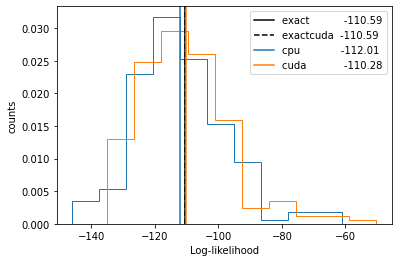

In [34]:
import matplotlib.pyplot as plt
plt.hist(nll_samples_cpu, histtype='step', color='C0', density=True)
plt.hist(nll_samples_cuda, histtype='step', color='C1', density=True)


plt.axvline(nll_exact,color='k', label=f'{"exact":<15} {nll_exact.item():.2f}')
plt.axvline(nll_exact_cuda,color='k', ls = '--', label=f'{"exactcuda":<10} {nll_exact_cuda.item():.2f}')

plt.axvline(nll_samples_cpu.mean(),color='C0', label=f'{"cpu":<15} {nll_samples_cpu.mean().item():.2f}')
plt.axvline(nll_samples_cuda.mean(),color='C1', label=f'{"cuda":<15} {nll_samples_cuda.mean().item():.2f}')
plt.xlabel('Log-likelihood')
plt.ylabel('counts')
plt.legend()

# Ensemble Hutch Trace Estimate as a surrogate for the Exact Trace Estimate

In [35]:
!pip install -U emcee

     |████████████████████████████████| 45 kB 3.7 MB/s 


## Sample One `idx = 31` graph, and condition
- ground truth:   
`([ 2.14894159, -0.79287613, -1.762911  ,  0.48976653, -0.14799766, -1.14266813,  1.8743024 ,  1.52000856])`
- could we **given a graph find the optimal condition**
- given a snapshot in say $z=2$, infer its $z=0$ properties?
- with `MCMC`

In [36]:
idx = 31
input_graph, input_cond = preprocess_inputs(dataset,31)
npcond = input_cond[0][0].numpy()

In [40]:
npcond.shape[0]

(12,)

In [ ]:
import emcee
ndim, nwalkers = npcond.shape[0], 32
p0 = np.random.randn(nwalkers, ndim)

nensemble_estimates = 200
device = 'cuda'
rtol = 1e-4
trace_method = 'hutch'

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    ensemble_log_prob, 
    args =[ 
           input_graph, 
           flow_cuda, 
           prior_cuda, 
           nensemble_estimates, 
           device, 
           rtol, 
           trace_method]
           )
sampler.run_mcmc(p0, 1000, progress=True)

 11%|█▏        | 113/1000 [1:54:32<15:27:14, 62.72s/it]

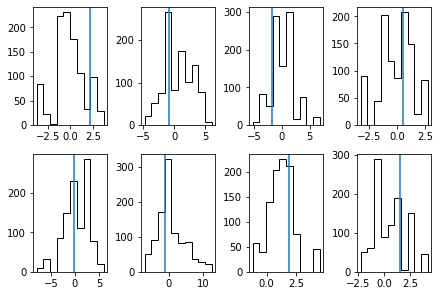

In [111]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)

f,ax = plt.subplots(2,4,constrained_layout=True)
for i in range(8):
  ax.flat[i].hist(samples[1000:, i], 10, color="k", histtype="step")
  ax.flat[i].axvline(input_cond[0].numpy()[0,i])
# plt.axvline(input_cond[0].numpy()[0,0])